In [1]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import PReLU
from scipy.signal import butter, lfilter, freqz
from sigma import get_glottal

In [2]:
model = keras.models.load_model(r'C:\Users\user\Desktop\segan_model_7')

In [3]:
def reconstruct_egg(speech):
    
    n = int((len(speech) - 2048)/1024) + 1
    
    dataset = np.zeros((n,2048,1))
    
    for i in range(n):
        dataset[i,:,0] = speech[1024*i:1024*i+2048]
    
    egg_windows = model.predict(dataset)[:,:,0]
    
    hann = 0.5*(1 - np.cos(np.pi*np.arange(2048)/1024))
    
    egg_windows[1:-1] = egg_windows[1:-1]*hann
    
    egg_windows[0,1024:] = egg_windows[0,1024:]*hann[1024:]
    
    egg_windows[-1,:1024] = egg_windows[-1,:1024]*hann[:1024]
    
    egg_reconstructed = np.zeros(2048 + (n-1)*1024)
    
    for i in range(n):
        egg_reconstructed[1024*i:1024*i+2048] = egg_reconstructed[1024*i:1024*i+2048] + egg_windows[i]
        
    return egg_reconstructed

In [4]:
egg_location = r"C:\Users\user\Desktop\dataset\egg\bdl_arctic_b0021.wav"
speech_location = r"C:\Users\user\Desktop\dataset\speech\bdl_arctic_b0021.wav"

egg, sr_egg = librosa.load(egg_location)
speech, _ = librosa.load(speech_location)

In [5]:
print(len(egg))
egg_recreated = reconstruct_egg(speech)
egg = egg[:len(egg_recreated)]
print(len(egg))

42006
41984


In [55]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 6
fs = sr_egg
cutoff = 500

egg_low_pass = butter_lowpass_filter(egg_recreated, cutoff, fs, order)

In [56]:
gci,goi = get_glottal(egg,sr_egg)
gci_rec,goi_rec = get_glottal(egg_low_pass,sr_egg)

gci_plot = np.zeros(len(egg))
goi_plot = np.zeros(len(egg))

gci_plot[gci] = 1
goi_plot[goi] = 1

gci_plot_rec = np.zeros(len(egg))
goi_plot_rec = np.zeros(len(egg))

gci_plot_rec[gci_rec] = 1
goi_plot_rec[goi_rec] = 1

C:\Users\user\sigma.py:22: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)
C:\Users\user\sigma.py:22: RuntimeWarning: invalid value encountered in true_divide
  group_delay = np.real(X_r/X)


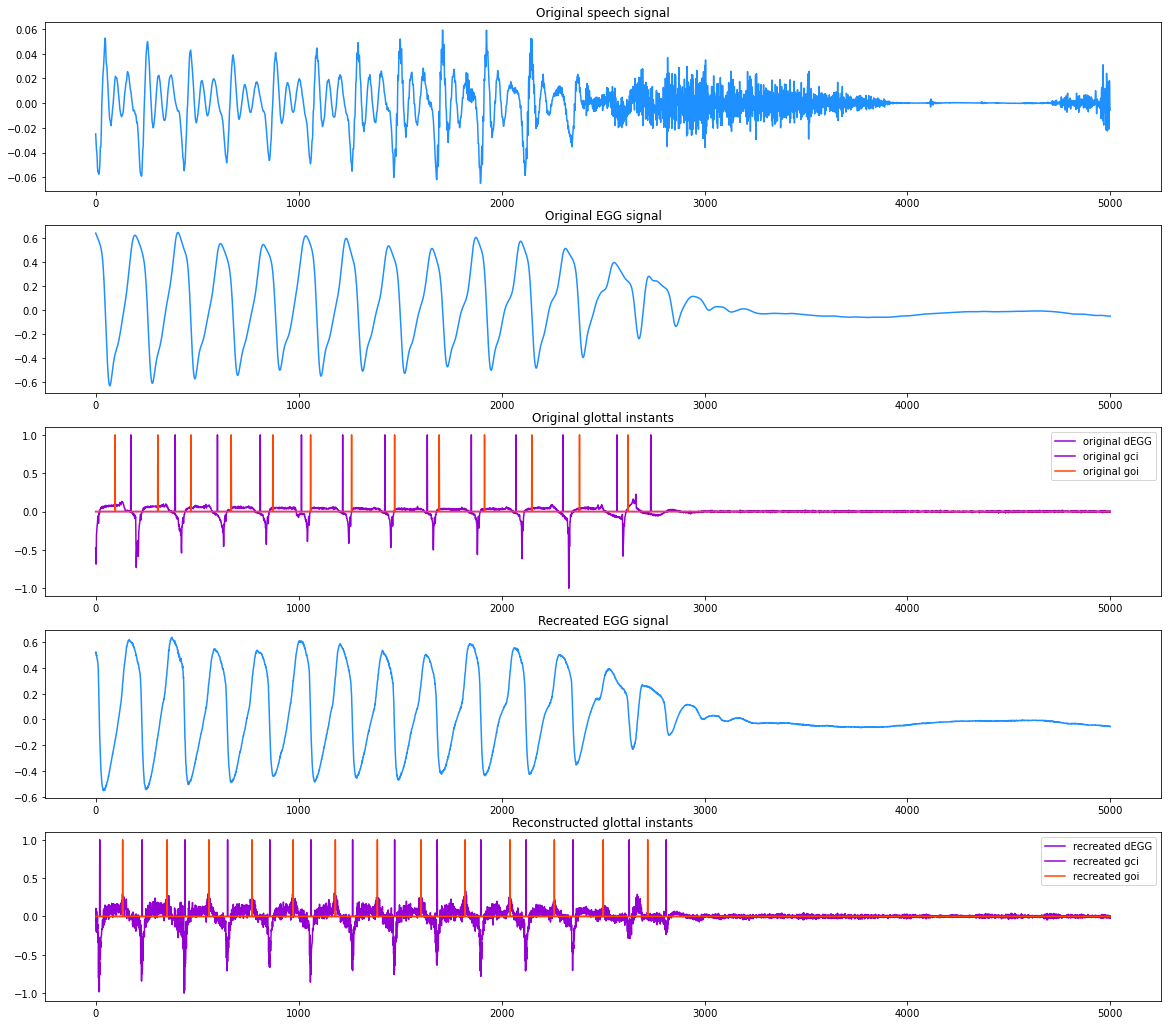

In [58]:
i = 25


f, imgs = plt.subplots(5,1,figsize=(20,18))

imgs[0].plot(speech[1000*i:1000*i + 5000],color = "dodgerblue")
imgs[0].set_title("Original speech signal")
imgs[1].plot(egg_low_pass[1000*i:1000*i + 5000],color = "dodgerblue")
imgs[1].set_title("Original EGG signal")
imgs[3].plot(egg_recreated[1000*i:1000*i + 5000],color = "dodgerblue")
imgs[3].set_title("Recreated EGG signal")
degg_rec = egg_recreated[1000*i:1000*i + 5000] - egg_recreated[1000*i - 1:1000*i + 5000 - 1]
imgs[4].plot(degg_rec/np.amax(np.abs(degg_rec)),label = "recreated dEGG",color = "darkviolet")
imgs[4].plot(gci_plot_rec[1000*i:1000*i + 5000],label = "recreated gci",color = "darkviolet")
imgs[4].plot(goi_plot_rec[1000*i:1000*i + 5000],label = "recreated goi",color = "orangered")
imgs[4].legend()
imgs[4].set_title("Reconstructed glottal instants")
degg_orig = egg[1000*i:1000*i + 5000] - egg[1000*i - 1:1000*i + 5000 - 1]
imgs[2].plot(degg_orig/np.amax(np.abs(degg_orig)),label = "original dEGG",color = "darkviolet")
imgs[2].plot(gci_plot[1000*i:1000*i + 5000],label = "original gci",color = "darkviolet")
imgs[2].plot(goi_plot[1000*i:1000*i + 5000],label = "original goi",color = "orangered")
imgs[2].set_title("Original glottal instants")
imgs[2].legend()

plt.savefig(r"C:\Users\user\Desktop\SEGAN outputs.png")